### This script reads in preproccessed data and plot Figure 1 in the paper.

In [1]:
import pickle
import os
import xarray as xr
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import linregress
import numpy as np
from utils import *

### read in climatological jet lat, sam index in models calculated in "calculate_SAM_index_models.ipynb"

In [2]:
save_directory = '../data'
with open(os.path.join(save_directory, 'sam_models_monthly_2000_2014.pkl'), 'rb') as f:
    sam_models_monthly = pickle.load(f)

with open(os.path.join(save_directory, 'sam_models_daily.pkl'), 'rb') as f:
    sam_models_daily = pickle.load(f)

In [3]:
save_directory = '/bjerknes_raid5/CMIP6_xl7pd/data'
# To load the dictionaries later
with open(os.path.join(save_directory, 'climatological_jet_lat_models_monthly_2000_2014.pkl'), 'rb') as f:
    climatological_jet_lat_models = pickle.load(f)

with open(os.path.join(save_directory, 'jet_lat_models.pkl'), 'rb') as f:
    jet_lat_models = pickle.load(f)

### calculating observed sam and jet-ACRE index using ERA5/MERRA2 and CERES data

In [4]:
def calculate_jet_latitude(file_name, level, ERA5=False, MERRA2=False):
    # Your implementation of calculate_jet_latitude
    dataset = xr.open_dataset(file_name,decode_cf=True)
    if ERA5:
        zonal_wind = dataset['ua'].sel(plev=level, method='nearest')
    elif MERRA2:
        zonal_wind = dataset['U'].sel(lev=level, method='nearest').mean(dim='lon')

    zonal_wind = zonal_wind.sortby('time')
    ua_pfj_zonal_mean = zonal_wind.sel(lat = slice(-65,-20)).sel(time = slice('2000','2014'))
    #print(ua_pfj_zonal_mean.values)
    numdays = len(ua_pfj_zonal_mean['time'][:])

    arrays = [np.full(numdays, np.nan) for _ in range(2)]
    jet_lat_pfj_daily_zonal_mean, jet_speed_pfj_daily_zonal_mean = arrays

    for i in range(numdays):
        jet_lat_pfj_daily_zonal_mean[i], jet_speed_pfj_daily_zonal_mean[i] = find_jet_lat(ua_pfj_zonal_mean[i,:], ua_pfj_zonal_mean.lat.values)
        
    jet_lat_pfj_daily_zonal_mean = pd.Series(jet_lat_pfj_daily_zonal_mean, index = ua_pfj_zonal_mean['time'][:])
    return jet_lat_pfj_daily_zonal_mean

In [5]:
climatological_jet_lat_models['model-mean'] = sum(climatological_jet_lat_models.values()) / len(climatological_jet_lat_models)
climatological_jet_lat_models['MERRA2'] = calculate_jet_latitude('/bjerknes_raid5/MERRA2_xl7pd/monthly/u_5levels/MERRA2_u_5levels.200001-202312.nc', 850, MERRA2=True).loc['2000':'2014'].mean()

In [6]:
climatological_jet_lat_models['obs'] = climatological_jet_lat_models['MERRA2']

In [7]:
sam_models_monthly['MERRA2'] = calculate_sam_models('/bjerknes_raid5/MERRA2_xl7pd/monthly/u_5levels/MERRA2_u_5levels.200001-202312.nc', MERRA2=True).sort_index()
sam_models_daily['MERRA2'] = calculate_sam_models('/bjerknes_raid5/MERRA2_xl7pd/MERRA2_daily_u_5levels.200001-202412.nc', MERRA2=True).sort_index()

read in done
(288, 505)
read in done
(5479, 505)


In [8]:
ds_ceres = xr.open_dataset(f'/bjerknes_raid5/CMIP6_xl7pd/CERES/CERES_EBAF_Ed4.2_Subset_200003-202309.nc')
ds_ceres['total_acre'] = ds_ceres['toa_cre_lw_mon'] - ds_ceres['sfc_cre_net_lw_mon']
ds_ceres.sortby('time')

dataset = ds_ceres.sel(time=slice('2000', '2014'))
dayofyear_mean = dataset.groupby('time.dayofyear').mean(dim='time')
anomaly = dataset.groupby('time.dayofyear') - dayofyear_mean
latitudes = dataset.variables['lat'][:]
acre_data = np.squeeze(anomaly.variables['total_acre'][:])

regression_coeffs_obs = np.zeros(len(latitudes))
p_values_obs = np.ones(len(latitudes))

for i, lat in enumerate(latitudes):
    if lat < 0:
        acre_data_lat_mean = np.nanmean(acre_data[:, i, :], axis=1)
        df = pd.DataFrame({
            #'sam index': sam_models_monthly['ERA5'].loc['2000-03':'2014'], # CERES data starts from 2000-03
            'sam index': sam_models_monthly['MERRA2'].loc['2000-03':'2014'],
            'acre_data_lat_mean': acre_data_lat_mean
        }).dropna()

        if len(df) > 1:
            slope, _, _, p_value, _ = linregress((df['sam index'] - df['sam index'].mean())/df['sam index'].std(), df['acre_data_lat_mean'])
            regression_coeffs_obs[i] = slope
            p_values_obs[i] = p_value  # Capture the p-value
        else:
            regression_coeffs_obs[i] = np.nan
            p_values_obs[i] = 1  # Default to non-significant if not enough data

### read in jet-ACRE index in models and interpolate to common grids

In [9]:
with open(os.path.join(save_directory, 'SAM_ACRE_index_models_monthly.pkl'), 'rb') as f:
    jet_ACRE_index_models = pickle.load(f)

# Define your common grid latitudes, for example:
common_latitudes = latitudes.values  # Common grid from -90 to 90 with 90 points, same as observations (ceres)

# Initialize an empty list to store interpolated arrays
jet_ACRE_index_interpolated= {}

# Loop through each array in reg_coeffs_type1
for model, coeffs in jet_ACRE_index_models.items():
    #if (model != 'MPI-ESM1-2-LR') & (model != 'INM-CM5-0'):
        # Define the original latitude grid for this array, for example:
        original_latitudes = np.linspace(-90, 90, coeffs.shape[0])

        # Create interpolation function for the current array
        interp_func = interp1d(original_latitudes, coeffs, kind='linear', fill_value='extrapolate')

        # Interpolate data to the new common grid
        new_coeffs = interp_func(common_latitudes)

        # Store the interpolated data
        jet_ACRE_index_interpolated[model] = new_coeffs

jet_ACRE_index_interpolated['model-mean'] = sum(jet_ACRE_index_interpolated.values()) / len(jet_ACRE_index_interpolated) 

In [10]:
# add observation jet-ACRE index into the dictionary
jet_ACRE_index_interpolated['obs'] = regression_coeffs_obs

In [27]:
with open(os.path.join(save_directory, 'SAM_ACRE_index_models_with_obs.pkl'), 'wb') as f:
    pickle.dump(jet_ACRE_index_interpolated, f)

In [11]:
jet_ACRE_index_interpolated_sorted = dict(sorted(jet_ACRE_index_interpolated.items()))
jet_ACRE_index_interpolated_sorted.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAS-ESM2-0', 'CIESM', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'EC-Earth3-CC', 'FGOALS-f3-L', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'SAM0-UNICON', 'UKESM1-0-LL', 'model-mean', 'obs'])

### plot the jet-ACRE index (model-mean and observed as thick lines and individual model as thin lines)

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_20141/3633892562.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('Regression Coefficients (W m$^{-2} \sigma_s^{-1}$)', fontsize=14)


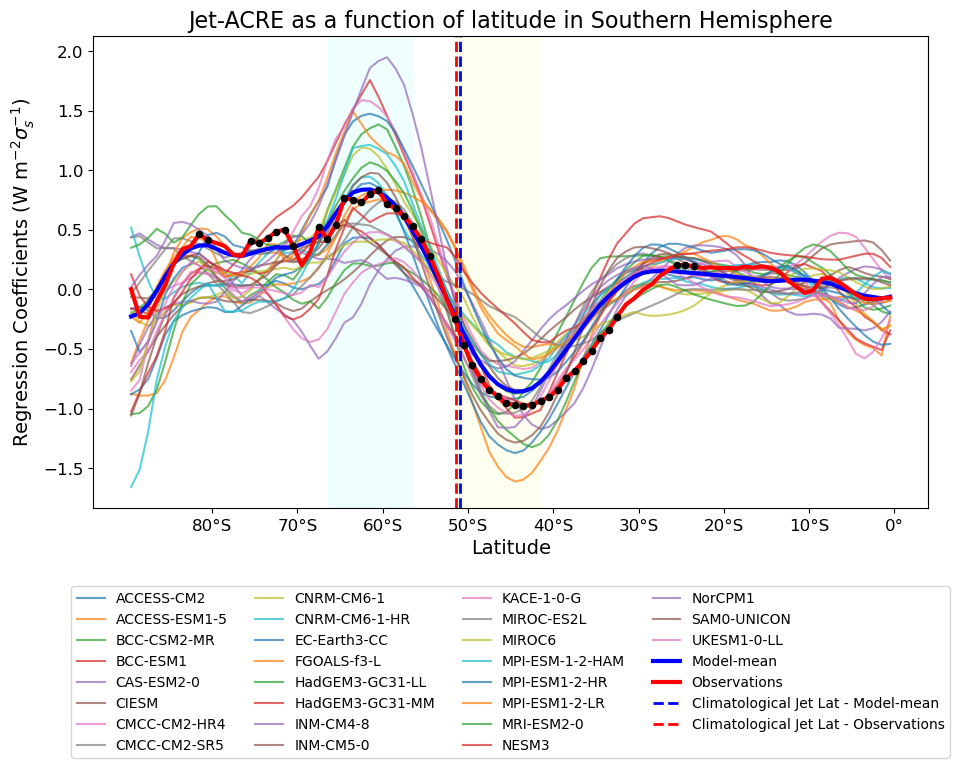

In [12]:
# Plotting
plt.figure(figsize=(10, 8))

# Plot each model
for model_name, coeffs in jet_ACRE_index_interpolated_sorted.items():
    if model_name == 'obs':
        plt.plot(common_latitudes[common_latitudes < 0], coeffs[common_latitudes < 0], label='Observations', color='red', linewidth=3)
    elif model_name == 'model-mean':
        plt.plot(common_latitudes[common_latitudes < 0], coeffs[common_latitudes < 0], label='Model-mean', color='blue', linewidth=3)
    elif model_name != 'IITM-ESM':
    #else:
        plt.plot(common_latitudes[common_latitudes < 0], coeffs[common_latitudes < 0], label=model_name, alpha=0.7)

plt.axvspan(climatological_jet_lat_models['MERRA2'], climatological_jet_lat_models['MERRA2']+10, color='lightyellow', alpha=0.5)
plt.axvspan(climatological_jet_lat_models['MERRA2']-15, climatological_jet_lat_models['MERRA2']-5, color='lightcyan', alpha=0.5)

plt.axvline(x=climatological_jet_lat_models['model-mean'], color='blue', linestyle='--', linewidth=2, label='Climatological Jet Lat - Model-mean')
plt.axvline(x=climatological_jet_lat_models['MERRA2'], color='red', linestyle='--', linewidth=2, label='Climatological Jet Lat - Observations')

# Add stippling for observations where p-values indicate significance (e.g., p < 0.05)
significant_obs = (p_values_obs < 0.05) & (common_latitudes < 0)
plt.scatter(common_latitudes[significant_obs], regression_coeffs_obs[significant_obs], color='black', s=20, marker='o', zorder = 10)

plt.title('Jet-ACRE as a function of latitude in Southern Hemisphere', fontsize=16)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Regression Coefficients (W m$^{-2} \sigma_s^{-1}$)', fontsize=14)
latitude_ticks = [-80, -70, -60, -50, -40, -30, -20, -10, 0]
latitude_labels = ['80°S', '70°S','60°S', '50°S','40°S','30°S', '20°S','10°S', '0°']
plt.xticks(latitude_ticks, latitude_labels, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10)
plt.tight_layout()

#plt.savefig('../figures/fig_1_jet_ACRE.eps', format='eps', dpi=1000)
plt.show()

In [13]:
jet_ACRE_index_40_50_all = {}
jet_ACRE_index_55_65_all = {}
jet_ACRE_index_gradient_all = {}
for model in jet_ACRE_index_interpolated.keys():
    coeffs_eq = np.nanmean(jet_ACRE_index_interpolated[model][(common_latitudes < climatological_jet_lat_models[model]+10) & (common_latitudes > climatological_jet_lat_models[model])])
    coeffs_po = np.nanmean(jet_ACRE_index_interpolated[model][(common_latitudes < climatological_jet_lat_models[model]-5) & (common_latitudes > climatological_jet_lat_models[model] - 15)])
    jet_ACRE_index_40_50_all[model] = coeffs_eq
    jet_ACRE_index_55_65_all[model] = coeffs_po
    jet_ACRE_index_gradient_all[model] = coeffs_eq - coeffs_po

In [14]:
sorted_jet_ACRE_index_gradient_all = dict(sorted(jet_ACRE_index_gradient_all.items(), key=lambda item: item[1]))
sorted_jet_ACRE_index_gradient_all

{'NorCPM1': -2.2177271855467033,
 'BCC-ESM1': -2.180526037169352,
 'BCC-CSM2-MR': -2.0269514764561403,
 'ACCESS-ESM1-5': -1.9826814765088596,
 'MRI-ESM2-0': -1.940804558055789,
 'CMCC-CM2-HR4': -1.9356156334440913,
 'EC-Earth3-CC': -1.8708054762667445,
 'SAM0-UNICON': -1.8440990292769341,
 'MPI-ESM1-2-HR': -1.820786782542789,
 'IITM-ESM': -1.817353429241091,
 'MPI-ESM-1-2-HAM': -1.6372008706709427,
 'obs': -1.5368868707938625,
 'MPI-ESM1-2-LR': -1.529248780125514,
 'model-mean': -1.4450514352727843,
 'CNRM-CM6-1': -1.3291838939290215,
 'CMCC-CM2-SR5': -1.3036339193044189,
 'UKESM1-0-LL': -1.2732164496715763,
 'HadGEM3-GC31-MM': -1.1923821522279392,
 'ACCESS-CM2': -1.1538521165225113,
 'CAS-ESM2-0': -1.0393993461700097,
 'CNRM-CM6-1-HR': -1.002953579617429,
 'HadGEM3-GC31-LL': -0.8992617019900184,
 'FGOALS-f3-L': -0.8911304187491086,
 'KACE-1-0-G': -0.8843696382509108,
 'INM-CM5-0': -0.881234674049589,
 'MIROC6': -0.8562531696919944,
 'CIESM': -0.8505502686308534,
 'NESM3': -0.821725844

### calculating SAM e-folding time in models and obs


In [15]:
sam_efolding_lag_models = {}
acf_values_models = {}
for name in sam_models_daily.keys(): 
    efolding_lag, acf_values = calculate_efolding_lag(sam_models_daily[name])
    # Store the computed efolding lag
    sam_efolding_lag_models[name] = efolding_lag
    acf_values_models[name] = acf_values

In [16]:
sam_efolding_lag_models

{'EC-Earth3-CC': 9.418095709727297,
 'ACCESS-ESM1-5': 9.2276389643054,
 'NESM3': 12.126160002033691,
 'CMCC-CM2-HR4': 8.6251036127213,
 'ACCESS-CM2': 10.707511720001165,
 'INM-CM4-8': 10.379051513295318,
 'INM-CM5-0': 12.551494219838286,
 'MPI-ESM-1-2-HAM': 10.200769149144865,
 'BCC-CSM2-MR': 10.939245050831461,
 'MPI-ESM1-2-HR': 9.488348466080119,
 'MIROC-ES2L': 13.739115057500191,
 'SAM0-UNICON': 7.84200594399173,
 'MIROC6': 9.086333429572084,
 'CMCC-CM2-SR5': 9.457218093546038,
 'MRI-ESM2-0': 9.697240191515005,
 'MPI-ESM1-2-LR': 16.97462759374968,
 'MERRA2': 8.872041665631421}

In [17]:
climatological_jet_lat_models

{'MIROC6': -51.07674781739758,
 'INM-CM4-8': -53.771444444444754,
 'BCC-ESM1': -49.161881742004525,
 'MRI-ESM2-0': -50.78124811111134,
 'CAS-ESM2-0': -49.18980282253717,
 'CMCC-CM2-HR4': -50.75844822571281,
 'MPI-ESM1-2-HR': -51.41238245833672,
 'HadGEM3-GC31-MM': -51.069436472574985,
 'HadGEM3-GC31-LL': -51.112777777778014,
 'UKESM1-1-LL': -50.88938888888913,
 'TaiESM1': -52.542299883653484,
 'ACCESS-ESM1-5': -50.820444444444696,
 'FIO-ESM-2-0': -53.142491855730256,
 'NESM3': -50.3695078718401,
 'NorESM2-LM': -53.09595029239803,
 'EC-Earth3-CC': -50.36983733333347,
 'ACCESS-CM2': -51.11755555555582,
 'BCC-CSM2-MR': -51.01208340665837,
 'NorCPM1': -52.51209064327522,
 'SAM0-UNICON': -52.01676643397343,
 'CNRM-CM6-1-HR': -47.333570016347664,
 'CAMS-CSM1-0': -49.23522855700208,
 'MPI-ESM-1-2-HAM': -51.435441228107656,
 'IITM-ESM': -49.09725316925681,
 'CMCC-CM2-SR5': -52.56006631762671,
 'CIESM': -51.75041942990129,
 'KACE-1-0-G': -51.5475555555558,
 'MPI-ESM1-2-LR': -50.831120175087015,

In [18]:
x = []
y = []
z = []
keys = []
for model, value in sam_efolding_lag_models.items():
    if model in climatological_jet_lat_models.keys():
    #if model != 'MERRA2':
        keys.append(model)
        x.append(value)
        y.append(climatological_jet_lat_models[model])
        #z.append(jet_ACRE_index_gradient_all[model])
print(np.corrcoef(x, y))

[[1.         0.31248916]
 [0.31248916 1.        ]]


### remove the impact of climatological jet

In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert lists to numpy arrays
y = np.array(y).reshape(-1, 1)
x = np.array(x)

# Perform linear regression
reg = LinearRegression().fit(y, x)

# Calculate residuals
x_residuals = x - reg.predict(y)

# Now z_residuals contains the values of z with the impact of y removed
print(x_residuals)

[-1.56814654 -1.51362376  1.13973864 -2.14986431  0.12777805  1.24214557
  2.79671248 -0.20614106  0.30216981 -0.931098    1.23416338 -2.24885783
 -1.515586   -0.3382723  -1.06533222  6.2391689  -1.54495481]


In [20]:
x_residuals_shifted = x_residuals + x.mean()
sam_efolding_lag_models_residuals = dict(zip(keys, x_residuals_shifted))

In [21]:
sam_efolding_lag_models_residuals

{'EC-Earth3-CC': 8.980794662609075,
 'ACCESS-ESM1-5': 9.035317441006493,
 'NESM3': 11.688679838080043,
 'CMCC-CM2-HR4': 8.399076886443947,
 'ACCESS-CM2': 10.676719246569967,
 'INM-CM4-8': 11.791086772134191,
 'INM-CM5-0': 13.345653679660032,
 'MPI-ESM-1-2-HAM': 10.342800137151471,
 'BCC-CSM2-MR': 10.85111101270685,
 'MPI-ESM1-2-HR': 9.617843197336555,
 'MIROC-ES2L': 11.783104580760016,
 'SAM0-UNICON': 8.300083369361392,
 'MIROC6': 9.033355198269701,
 'CMCC-CM2-SR5': 10.21066890186175,
 'MRI-ESM2-0': 9.483608975495558,
 'MPI-ESM1-2-LR': 16.788110096496276,
 'MERRA2': 9.003986387541786}

In [22]:
models_to_plot = sam_efolding_lag_models_residuals.keys() & jet_ACRE_index_40_50_all.keys()

### plot SAM timescale vs jet-ACRE index

In [23]:
def calculate_SAM_timescale_vs_jet_acre(jet_ACRE_index, sam_timescale_index, side):
    # Initialize lists to aggregate data across all models
    all_x_wo = []
    all_y_wo = []
    all_x = []
    all_y = []

    # Plot the scatter plot with unique markers for each model
    models_to_plot = jet_ACRE_index.keys() & sam_timescale_index.keys()
    for model in models_to_plot:
        x = jet_ACRE_index[model]
        y = sam_timescale_index[model]
        all_x.append(x)
        all_y.append(y)

        if (model != 'MPI-ESM1-2-LR'):
            x = jet_ACRE_index[model]
            y = sam_timescale_index[model]
            # Aggregate data across models
            all_x_wo.append(x)
            all_y_wo.append(y)
        
    # Convert the lists to numpy arrays
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    model_mean_x = np.nanmean(all_x)
    model_mean_y = np.nanmean(all_y)

    #x_obs_eq = np.nanmean(regression_coeffs_obs[(latitudes < -40) & (latitudes > -50)])
    #x_obs_po = np.nanmean(regression_coeffs_obs[(latitudes < -55) & (latitudes > -65)])
    x_obs = jet_ACRE_index['obs']
    #y_obs = sam_timescale_index['ERA5']
    y_obs = sam_timescale_index['MERRA2']
    '''
    if side=='po':
        x_obs = x_obs_po
    elif side=='eq':
        x_obs = x_obs_eq
    else:
        x_obs = x_obs_eq - x_obs_po
    '''
    all_x = np.append(all_x, x_obs)
    all_y = np.append(all_y, y_obs)
    all_x_wo = np.append(all_x_wo, x_obs)
    all_y_wo = np.append(all_y_wo, y_obs)

    pearson_correlation = pearsonr(all_x, all_y).statistic
    p_value = pearsonr(all_x, all_y).pvalue
    spearman_correlation, _ = spearmanr(all_x, all_y)
    pearson_correlation_wo = pearsonr(all_x_wo, all_y_wo).statistic
    p_value_wo = pearsonr(all_x_wo, all_y_wo).pvalue
    print(p_value_wo)
    spearman_correlation_wo, _ = spearmanr(all_x_wo, all_y_wo)
    # Fit a line across the aggregated data
    z = np.polyfit(all_x, all_y, 1)
    p = np.poly1d(z)

    z_wo = np.polyfit(all_x_wo, all_y_wo, 1)
    p_wo = np.poly1d(z_wo)

    return all_x, all_y, all_x_wo, all_y_wo, p, p_wo, pearson_correlation, pearson_correlation_wo, p_value, p_value_wo, x_obs, y_obs, model_mean_x, model_mean_y

In [24]:
import itertools
def plot_sam_timescale_vs_jet_acre(ax, jet_ACRE_index, sam_timescale_index, side, title, panel_label, outlier=False):
    all_x, all_y, all_x_wo, all_y_wo, p, p_wo, pearson_correlation, pearson_correlation_wo, p_value, p_value_wo, x_obs, y_obs, model_mean_x, model_mean_y = calculate_SAM_timescale_vs_jet_acre(jet_ACRE_index, sam_timescale_index, side)
    # Define a list of markers to use
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', 'x', '*', 'H', '+', '|', '_', 'd', 'P', 'X', '1', '2', '3', '4', '8', '.', ',']
    # Create an iterator to cycle through markers
    marker_iterator = itertools.cycle(markers)
    # Plot the scatter plot with unique markers for each model
    models_to_plot = jet_ACRE_index.keys() & sam_timescale_index.keys()
    for model in sorted(models_to_plot):
        #if (model != 'MPI-ESM1-2-LR') & (model != 'INM-CM5-0'):
        if model == 'MPI-ESM1-2-LR':
            marker = next(marker_iterator)  # Get the next marker
            x = jet_ACRE_index[model]
            y = sam_timescale_index[model]
            #ax.scatter(x, y, label=model + ' (outlier)', marker=marker)
            ax.scatter(x, y, label=model, marker=marker)
        else:
            marker = next(marker_iterator)  # Get the next marker
            x = jet_ACRE_index[model]
            y = sam_timescale_index[model]
            # Scatter plot for each model
            ax.scatter(x, y, label=model, marker=marker)
    # Plot the overall trend line
    ax.plot(all_x, p(all_x), linestyle='-', color='gray', linewidth=0.5)
    ax.plot(all_x_wo, p_wo(all_x_wo), linestyle='-', color='black', linewidth=0.5)
    ax.scatter(x_obs, y_obs, label='Observations', marker='o', color='red', s=100)
    ax.scatter(model_mean_x, model_mean_y, label='Model-mean', marker='o', color='blue', s=100)
    ax.text(0.1, 1.07, panel_label, transform=ax.transAxes, fontsize=12,  va='top', ha='right')

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel('Jet-ACRE (W m$^{-2} \sigma_s^{-1}$)')
    #ax.set_ylabel('SAM timescale (days)')

    if p_value < 0.05:
        pvalue_text = 'p < 0.05'
    elif p_value < 0.1:
        pvalue_text = 'p < 0.1'
    else:
        pvalue_text = 'p > 0.1'

    if p_value_wo < 0.05:
        pvalue_text_wo = 'p < 0.05'
    elif p_value_wo < 0.1:
        pvalue_text_wo = 'p < 0.1'
    else:
        pvalue_text_wo = 'p > 0.1'
    # Add the correlation as text on the plot
    ax.text(0.05, 0.95, f'r = {pearson_correlation:.2f}' + ' (' + pvalue_text +')', fontsize=12, ha='left', va='top', transform=ax.transAxes, color='gray')
    #ax.text(0.05, 0.90, f'spearman r = {spearman_correlation:.2f}', fontsize=12, ha='left', va='top', transform=ax.transAxes)
    ax.text(0.05, 0.85, f'r w/o outlier= {pearson_correlation_wo:.2f}' + ' (' + pvalue_text_wo +')', fontsize=12, ha='left', va='top', transform=ax.transAxes, color='black')
    #ax.text(0.05, 0.80, f'spearman r w/o outlier = {spearman_correlation_wo:.2f}', fontsize=12, ha='left', va='top', transform=ax.transAxes)

<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_20141/1381467489.py:33: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Jet-ACRE (W m$^{-2} \sigma_s^{-1}$)')


### Plotting Figure 4

0.021710192056857584
0.06998429570203818
0.0032411169679906968


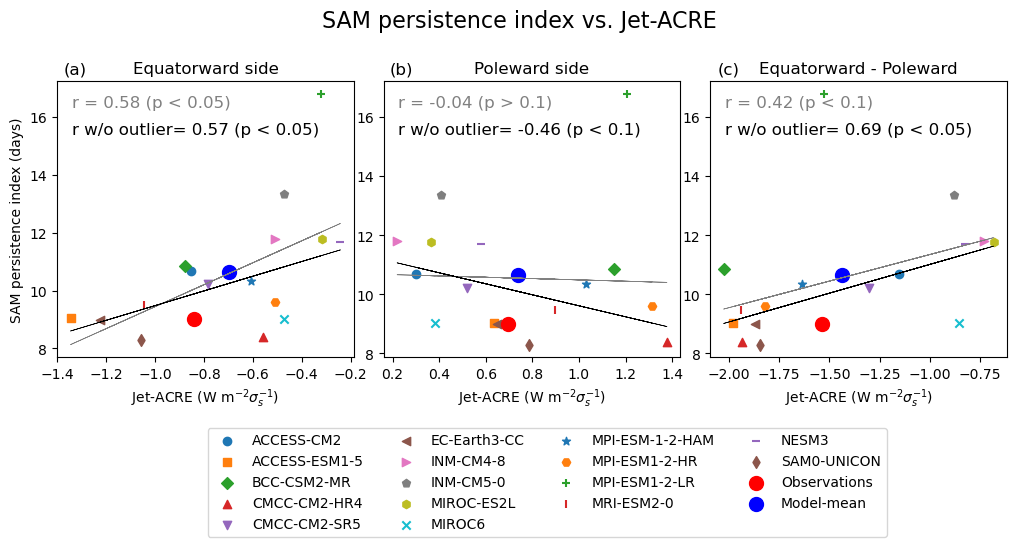

In [25]:
# Create a 3-panel figure
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
fig.subplots_adjust(wspace=0.1, right = 0.6, top = 0.8)
# Plot each panel using the axes provided by subplots
plot_sam_timescale_vs_jet_acre(axs[0], jet_ACRE_index_40_50_all, sam_efolding_lag_models_residuals, "eq", 'Equatorward side','(a)')
plot_sam_timescale_vs_jet_acre(axs[1], jet_ACRE_index_55_65_all, sam_efolding_lag_models_residuals, "po", 'Poleward side','(b)')
plot_sam_timescale_vs_jet_acre(axs[2], jet_ACRE_index_gradient_all, sam_efolding_lag_models_residuals, "gradient", 'Equatorward - Poleward','(c)')

# Get the handles and labels
handles, labels = axs[2].get_legend_handles_labels()
# Create a list of labels excluding 'Model-mean' and 'Observations'
filtered_labels_handles = [(label, handle) for label, handle in zip(labels, handles)
                           if label not in ['Model-mean', 'Observations']]
# Sort the filtered labels alphabetically
sorted_labels_handles = sorted(filtered_labels_handles, key=lambda x: x[0])
# Add 'Model-mean' and 'Observations' to the end
final_labels_handles = sorted_labels_handles + [
    (label, handle) for label, handle in zip(labels, handles) 
    if label in ['Model-mean', 'Observations']
]

# Unpack sorted labels and handles
sorted_labels, sorted_handles = zip(*final_labels_handles)
axs[0].set_ylabel('SAM persistence index (days)')
fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.37, -0.05), ncol=4)

# Add a common title for all subplots
fig.suptitle('SAM persistence index vs. Jet-ACRE', fontsize=16, x=0.356)

#plt.tight_layout()  # Adjust the layout to fit the suptitle
#fig.savefig('../figures/fig_4_SAM_persistence_index_vs_Jet_ACRE_index_remove_climatological_jet.eps', format='eps', dpi=1000, bbox_inches='tight')
#fig.savefig('../figures/fig_4_SAM_persistence_index_vs_Jet_ACRE_index_remove_climatological_jet.png', format='png', dpi=1000, bbox_inches='tight')
plt.show()

### Plotting Figure S5

0.02300665849767051
0.136812630996579
0.008703774144181772


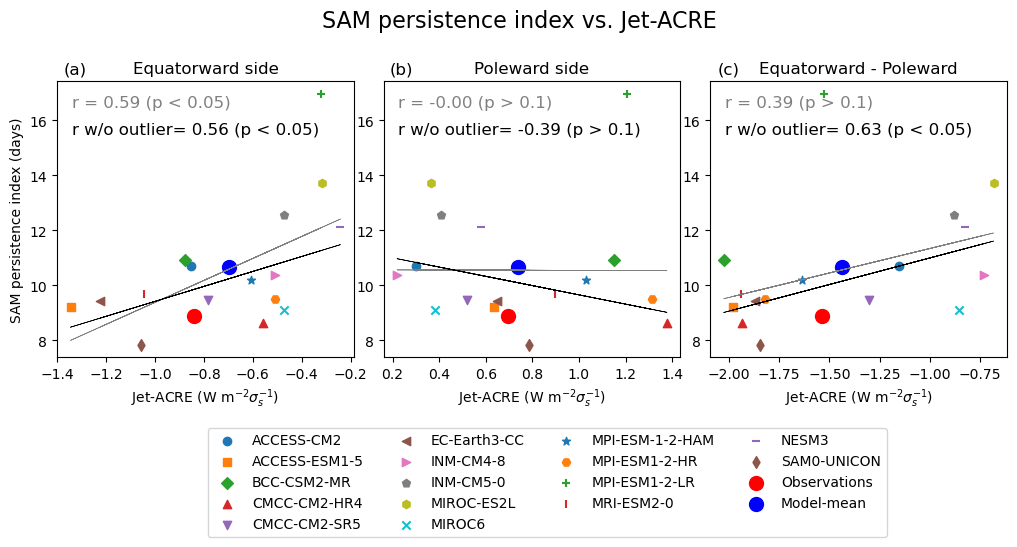

In [26]:
# Create a 3-panel figure
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
fig.subplots_adjust(wspace=0.1, right = 0.6, top = 0.8)
# Plot each panel using the axes provided by subplots
plot_sam_timescale_vs_jet_acre(axs[0], jet_ACRE_index_40_50_all, sam_efolding_lag_models, "eq", 'Equatorward side','(a)')
plot_sam_timescale_vs_jet_acre(axs[1], jet_ACRE_index_55_65_all, sam_efolding_lag_models, "po", 'Poleward side','(b)')
plot_sam_timescale_vs_jet_acre(axs[2], jet_ACRE_index_gradient_all, sam_efolding_lag_models, "gradient", 'Equatorward - Poleward','(c)')

# Get the handles and labels
handles, labels = axs[2].get_legend_handles_labels()
# Create a list of labels excluding 'Model-mean' and 'Observations'
filtered_labels_handles = [(label, handle) for label, handle in zip(labels, handles) 
                           if label not in ['Model-mean', 'Observations']]
# Sort the filtered labels alphabetically
sorted_labels_handles = sorted(filtered_labels_handles, key=lambda x: x[0])
# Add 'Model-mean' and 'Observations' to the end
final_labels_handles = sorted_labels_handles + [
    (label, handle) for label, handle in zip(labels, handles) 
    if label in ['Model-mean', 'Observations']
]

# Unpack sorted labels and handles
sorted_labels, sorted_handles = zip(*final_labels_handles)
axs[0].set_ylabel('SAM persistence index (days)')
fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.37, -0.05), ncol=4)

# Add a common title for all subplots
fig.suptitle('SAM persistence index vs. Jet-ACRE', fontsize=16, x=0.356)

#plt.tight_layout()  # Adjust the layout to fit the suptitle
#fig.savefig('../figures/fig_s5_original_SAM_persistence_index_vs_Jet_ACRE_index.eps', format='eps', dpi=1000, bbox_inches='tight')
plt.show()